# Goal

The goal of this notebook is to help in interactively developing the new multi-objective version of the Tomograph.

## Goals for the Tomograph

1. Move away from matplotlib to either plotly, or bokeh. 
2. Make sure that:
    1. All scales are the same so that they are comparable.
    2. We should be able to plot not just predictions but also individual observations as a scatterplot. 
    3. We should be able to link the points across multiple charts to investigate them more deeply (bokeh seems to be the winner here)
    4. We should be able to connect multiple tomographs to the same optimizer, as any given analysis might focus on different aspects and each aspect should have it's own graphs.
3. The Tomograph produces a set of heatmaps that belong to 2D cross-sections of the higher-dimensional hypercube. All these cross-sections share a single point (often the optimum). The user should be able to:
    1. Select one of the predefined points (different types of optima, maybe optima for different contexts)
    2. View the resulting cross sections and sensitivity analysis for such a point
    3. Be able to use sliders to adjust the point so that they can easily "walk the hypercube"
    

Plotly has the advantage of also enabling 3D visualizations of the pareto frontier and generates surface plots etc. But bokeh has built-in support for linking data. 

Given what we need, I would start with bokeh, for dabl-style and tomograph plots, and then switch to plotly for parameter interactions, and 3D pareto visualizations.

https://docs.bokeh.org/en/latest/index.html

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory, objective_function_config_store
objective_function_config_store.list_named_configs()

[Name: default
 
 Description: None
 
 Config Values: {
   "implementation": "Hypersphere",
   "hypersphere_config.num_objectives": 3,
   "hypersphere_config.minimize": "all",
   "hypersphere_config.radius": 10,
   "description": "default"
 },
 Name: three_level_quadratic
 
 Description: None
 
 Config Values: {
   "implementation": "ThreeLevelQuadratic"
 },
 Name: flower
 
 Description: None
 
 Config Values: {
   "implementation": "Flower"
 },
 Name: noisy_polynomial_objective
 
 Description: None
 
 Config Values: {
   "implementation": "PolynomialObjective",
   "polynomial_objective_config.seed": 17,
   "polynomial_objective_config.input_domain_dimension": 2,
   "polynomial_objective_config.input_domain_min": -1024,
   "polynomial_objective_config.input_domain_width": 2048,
   "polynomial_objective_config.max_degree": 2,
   "polynomial_objective_config.include_mixed_coefficients": true,
   "polynomial_objective_config.percent_coefficients_zeroed": 0,
   "polynomial_objective_config

In [3]:
#objective_function_config = objective_function_config_store.get_config_by_name("multi_objective_2_mutually_exclusive_polynomials")
#objective_function_config = objective_function_config_store.get_config_by_name("three_level_quadratic")
objective_function_config = objective_function_config_store.get_config_by_name("2d_hypersphere_minimize_none")
objective_function_config = objective_function_config_store.get_config_by_name("multi_objective_waves_3_params_2_objectives_half_pi_phase_difference")

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)
optimization_problem = objective_function.default_optimization_problem

In [4]:
print(objective_function.default_optimization_problem)

In [5]:
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory, bayesian_optimizer_config_store
optimizer_factory = BayesianOptimizerFactory()
optimizer_config = bayesian_optimizer_config_store.default
optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=optimizer_config,
    optimization_problem=optimization_problem
)

03/17/2021 19:12:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.7,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_m

03/17/2021 19:12:22 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_2_input_space
  Dimensions:
    domain___x_0: [0.00, 6.28]
    contains_context: {False}
    domain___x_2: [0.00, 6.28]
    domain___x_1: [0.00, 6.28]
03/17/2021 19:12:22 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_3_input_space
  Dimensions:
    contains_context: {False}
    domain___x_1: [0.00, 6.28]
    domain___x_2: [0.00, 6.28]
    domain___x_0: [0.00, 6.28]
03/17/2021 19:12:22 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_4_input_space
  Dimensions:
    domain___x_0

In [6]:
params_df = objective_function.parameter_space.random_dataframe(num_samples=2000)
objectives_df = objective_function.evaluate_dataframe(params_df)

In [7]:
optimizer.register(parameter_values_pandas_frame=params_df, target_values_pandas_frame=objectives_df)

03/17/2021 19:12:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 153 -                  register() ] Registering 2000 parameters and 2000 objectives.


In [8]:
from mlos.Spaces import Point
from mlos.OptimizerMonitoring.Tomograph.ModelTomograph import ModelTomograph

tomograph = ModelTomograph(optimizer=optimizer)

In [9]:
config = objective_function.parameter_space.random()

In [10]:
import os
os.getpid()

691680

{
  "x_0": 1.919360117893022,
  "x_1": 4.367419358031192,
  "x_2": 1.0387580489124366
}


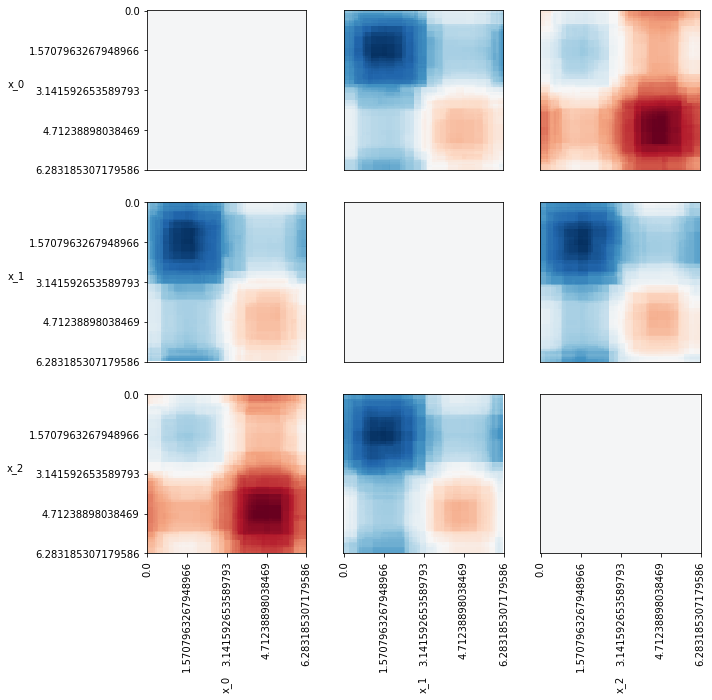

In [11]:
tomograph.plot()

## Plotting Observations
The goal of this next section is to plot all observations on a grid where:
   1. On the diagonal we plot a single parameters vs. objective value (basically what dabl does already)
   2. On the other subgraphs we plot two parameters colored according to the objective function value. Additionally, we can also regulate their opacity as a function of their distance from the plane of the graph.

In [12]:
params_df, objectives_df, context_df = optimizer.get_all_observations()
pareto_df = optimizer.pareto_frontier.pareto_df

In [13]:
from typing import List


from bokeh.layouts import gridplot, column
from bokeh.models import CategoricalTicker, ColorBar, ColumnDataSource, Div, HoverTool, LinearColorMapper
from bokeh.plotting import figure
from bokeh.transform import factor_mark
from bokeh.models.widgets import DataTable, TableColumn

import pandas as pd

from mlos.Logger import create_logger
from mlos.Optimizers.OptimizationProblem import OptimizationProblem
from mlos.Optimizers.OptimizerBase import OptimizerBase
from mlos.OptimizerMonitoring.Tomograph.GridPlot import GridPlot
from mlos.OptimizerMonitoring.Tomograph.ObservationsDataSource import ObservationsDataSource

from mlos.Spaces import CategoricalDimension, Point
from mlos.Spaces.HypergridAdapters import CategoricalToDiscreteHypergridAdapter
from mlos.Utils.KeyOrderedDict import KeyOrderedDict


from bokeh.io import output_notebook, show
from mlos.OptimizerMonitoring.Tomograph.ModelTomograph2 import ModelTomograph2    
    
    
    
    
    
        
output_notebook()       
tomograph2 = ModelTomograph2(optimizer=optimizer)
observations_plot = tomograph2.get_observations_plot()
out

Loading BokehJS ...

In [14]:
params_df

,x_0,x_1,x_2
0,3.115763,1.484565,3.767856
1,4.861551,5.549235,3.943980
2,5.717527,2.247444,1.401049
3,2.388861,3.447009,2.930750
4,1.635290,0.672534,2.585657
...,...,...,...
1995,4.267437,5.600560,0.751862
1996,5.246546,2.730239,3.584350
1997,2.485451,3.323277,2.129967
1998,5.777946,2.630359,3.727321


In [15]:
     
observations_data_source = ObservationsDataSource(
    optimization_problem=optimization_problem,
    parameters_df=params_df,
    context_df=context_df,
    objectives_df=objectives_df,
    pareto_df=pareto_df
)

In [16]:
tomograph2.plot_observations(objective_names=optimization_problem.objective_names)